In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Import packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 4.0)
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot
import cufflinks as cf
pd.options.display.max_columns = 30
cf.go_offline()
cf.set_config_file(world_readable=True, theme='pearl')
from wordcloud import WordCloud
import seaborn as sns
import tweepy
import json
from preprocessing_functions import preprocessing
from textblob import TextBlob

In [2]:
# Storing OAuth authentication credentials in relevant variables
access_token = "79480938-s6MD3n3gzsQc5PIoetBl4l4iEb9Dr8kneLn56wFZG"
access_token_secret = "MG9XAUUDzzzfNsymRKV1i2Lz4Ii0HZlS2xAORXCw1QipR"
consumer_key = "lOcRtMo0OdOGHT5isdZ6VtF2t"
consumer_secret = "kdODRypz3OdwDEf06WdSrQ21Gdt01ya2wnwB9MIvgRKgbaz8IQ"

# Passing OAuth details to tweepy's OAuth handler
auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api=tweepy.API(auth)

In [3]:
# Creating function to scrape tweets from Sinalite twitter homepage
def all_tweets(user_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method

    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)

    #initialize a list to hold all the Tweets
    tweets_list = []

    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = user_name,count=200)

    #save most recent tweets
    tweets_list.extend(new_tweets)

    #save the id of the oldest tweet less one
    old = tweets_list[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print ("getting tweets before %s" % (old))

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = user_name,count=200,max_id=old)

        #save most recent tweets
        tweets_list.extend(new_tweets)

        #update the id of the oldest tweet less one
        old = tweets_list[-1].id - 1
        print ("...%s tweets downloaded so far" %(len(tweets_list)))
    #transform the tweepy tweets into a 2D array that will populate the csv	
    finaltweets = [[tweet.id_str, tweet.created_at, tweet.text] for tweet in tweets_list]
    return finaltweets

In [4]:
# Storing tweets in a variable for sinalite
sl=all_tweets('sinalite')

getting tweets before 974016084570337279
...400 tweets downloaded so far
getting tweets before 930873127252451328
...600 tweets downloaded so far
getting tweets before 895006382998433791
...800 tweets downloaded so far
getting tweets before 811694718320943103
...999 tweets downloaded so far
getting tweets before 148859093807935488
...1085 tweets downloaded so far
getting tweets before 2669798222
...1085 tweets downloaded so far


In [23]:
#Converting into dataframe
sldf=pd.DataFrame(sl)
#Renamiing the columns
sldf.columns=['id','date','tweet']
#First 5 rows
sldf.head()
#Dimension of the dataframe
sldf.shape
#Dropping any existing duplictates
sldf=sldf.drop_duplicates()
#Again checking the shape after dropping duplicates
sldf.shape # Shows there were no duplicates
#Features information
sldf.info()

,id,date,tweet
0,1106561279597137920,2019-03-15 14:22:22,See 👀those packages on the bottom right? Those...
1,1106289096391979008,2019-03-14 20:20:49,Attending the #AllianceFranchise Brands event ...
2,1106270479256559616,2019-03-14 19:06:50,Hello from the Alliance Franchise Brands event...
3,1106231458832793607,2019-03-14 16:31:47,Come and meet @SinaLite at 👉Booth #434 at Alli...
4,1104097504679714816,2019-03-08 19:12:12,A women's heart holds the light that guides yo...


(1085, 3)

(1085, 3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 3 columns):
id       1085 non-null object
date     1085 non-null datetime64[ns]
tweet    1085 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 33.9+ KB


In [24]:
# Preprocessing tweets to get clean tweets
sldf.tweet=preprocessing(sldf.tweet)
sldf.head()

,id,date,tweet
0,1106561279597137920,2019-03-15 14:22:22,see package bottom right new specialty samplek...
1,1106289096391979008,2019-03-14 20:20:49,attend alliancefranchise brand event grapevine...
2,1106270479256559616,2019-03-14 19:06:50,hello alliance franchise brand event grapvine ...
3,1106231458832793607,2019-03-14 16:31:47,come meet booth alliance franchise brand conve...
4,1104097504679714816,2019-03-08 19:12:12,womens heart hold light guide even dark tunnel...


In [25]:
sldf['polarity'] = sldf.tweet.map(lambda text: TextBlob(text).sentiment.polarity)
sldf.head()

,id,date,tweet,polarity
0,1106561279597137920,2019-03-15 14:22:22,see package bottom right new specialty samplek...,0.424026
1,1106289096391979008,2019-03-14 20:20:49,attend alliancefranchise brand event grapevine...,0.000000
2,1106270479256559616,2019-03-14 19:06:50,hello alliance franchise brand event grapvine ...,0.000000
3,1106231458832793607,2019-03-14 16:31:47,come meet booth alliance franchise brand conve...,0.000000
4,1104097504679714816,2019-03-08 19:12:12,womens heart hold light guide even dark tunnel...,0.350000


In [94]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = sldf.loc[sldf.polarity == 1, ['tweet']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

awesome
perfect time consider sell wallcalendars clients hurry amp avail discount till
agreeprinters advice get best outcome
holidaytips stand crowd custom greet holiday card best way make impact
interestingfact retail professionals indicate emailmarketing greatest driver customer


In [95]:
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = sldf.loc[sldf.polarity == 0, ['tweet']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

think buy banners matte vinyl read review via
trend spot road ahead print pave gold silver varnish printmed
up fedex customers printchat
smell inkhahahaha printchat
join fastsigns outside sales summit fasttrack


In [36]:
#Minimum polarity of most negative tweet
sldf.polarity.min()

#number of tweets with negative polarity
npt=sldf.polarity[sldf.polarity<0.0].count()
print('Number of negative polarity tweet: \n',(npt))

-0.8

Number of negative polarity tweet: 
 55


In [114]:
sldf['polarity'].iplot(
    kind='hist',
    bins=20,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

## Cues:
- Majority of the tweets polarity is greater than or equal to 0, which implies majority of the tweets language is either positive or neutral. Which shows that SinaLite majorly uses positive terms and phrases in their communication with consumers.

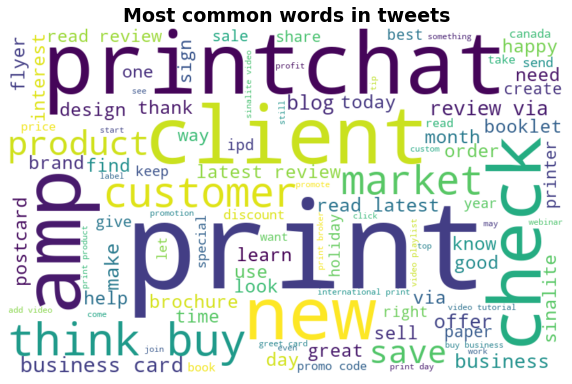

In [37]:
def most_common_visual(input_column):
        """Most common words in tweets"""
        words = ' '.join([t for t in input_column])
        wordcloud = WordCloud(width=800, height=500, random_state=21,max_words=100, background_color="white").generate(words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title("Most common words in tweets",fontdict={'fontsize':19,'fontweight':'bold'})
        plt.axis('off')
        plt.show()

most_common_visual(sldf.tweet)

## Cues:
- Through tweets, SinaLite implies that they are client-centric and always add new products to cater to the evolving client needs.
- SinaLite didn’t feature as one of the frequently used terms/words.

## Considerations:
- Creating #tag for company name to index it on Twitter.

- #sinalite to be always used in every company tweet / brandcom in order to increase the digital footprints and boost the search algorithm.

- Daily tweet with #tag to boost the SEO algorithm for SinaLite on twitter and on other search engines resulting in a wider scale branding.